In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/مشروع تنقيب البيانات/03-02-2018.csv")

In [3]:
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,61.444444,87.534438,1460,0,539.000000,655.432936,30597.305230,113.166177,9425.666667,19069.116850,73403.0,1.0,141385.0,17673.1250,23965.32327,73403.0,22.0,51417.0,8569.50000,13036.89082,31525.0,1.0,0,0,0,0,192,152,63.655975,49.510203,0,1460,254.470588,474.712955,225352.389700,0,0,1,1,0,0,0,1,0,270.375000,61.444444,539.000000,0,0,0,0,0,0,9,553,7,3773,8192,119,4,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,19.000000,26.870058,0,0,0.000000,0.000000,135231.316700,10676.156580,140.500000,174.655375,264.0,17.0,281.0,281.0000,0.00000,281.0,281.0,0.0,0.00000,0.00000,0.0,0.0,1,0,0,0,40,20,7117.437722,3558.718861,0,38,19.000000,21.939310,481.333333,0,1,0,0,1,0,0,0,0,25.333333,19.000000,0.000000,0,0,0,0,0,0,2,38,1,0,123,0,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,1460,0,701.800000,636.314186,41501.086400,92.915547,11192.960000,24379.448340,112589.0,1.0,279728.0,27972.8000,36167.74032,112589.0,94.0,258924.0,18494.57143,36356.50372,133669.0,1.0,0,0,0,0,232,312,39.310424,53.605123,0,1460,430.111111,566.234209,320621.179500,0,0,1,1,0,0,0,1,1,446.653846,98.727273,701.800000,0,0,0,0,0,0,11,1086,15,10527,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,15151.515150,132.000000,0.000000,132.0,132.0,132.0,132.0000,0.00000,132.0,132.0,0.0,0.00000,0.00000,0.0,0.0,0,0,0,0,40,0,15151.515150,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,2,0,0,0,256,-1,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,1460,0,472.384615,611.180489,27100.607260,80.287282,13048.380950,26311.627030,114077.0,1.0,273946.0,34243.2500,37996.56546,114077.0,201.0,252994.0,21082.83333,39075.73819,135611.0,1.0,0,0,0,0,192,272,32.844797,47.442485,0,1460,322.869565,497.254764,247262.300400,0,0,1,1,0,0,0,1,1,337.545455,142.777778,472.384615,0,0,0,0,0,0,9,1285,13,6141,8192,1047,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,3389,6,02/03/2018 02:08:18,3982183,14,8,1442,1731.0,725,0,103.000000,191.125412,1179,0,216.375000,405.464791,796.799143,5.524608,189627.761900,257112.296400,953396.0,34.0,3982183.0,306321.7692,340816.37320,1221092.0,23468.0,3930879.0,561554.14290,350274.78920,953825.0,131451.0,0,0,0,0,292,172,3.515660,2.008948,0,1179,137.956522,278.879491,77773.770750,0,0,1,1,0,0,0,1,0,144.2

#Data Cleaning

##Checking data availability

In [4]:
print(f"There are {df.isnull().sum().sum()} NULL values in the data frame")

There are 2558 NULL values in the data frame


Because we have a very large dataset, we will drop those null values.

In [5]:
df = df.dropna()
print(f"After droping there are {df.isnull().sum().sum()} NULL values in the data frame")

After droping there are 0 NULL values in the data frame


In [6]:
df.duplicated().sum()

5459

In [7]:
df.drop_duplicates(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df.duplicated().sum()

0

In [9]:
df = df.reset_index(drop=True)

In [10]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1040558.0,1040558.0,1040558.0,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1040558.0,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1040558.0,1040558.0,1040558.0,1040558.0,1040558.0,1040558.0,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06
mean,8.331223e+03,8.065133e+00,1.160292e+07,5.917336e+00,7.036866e+00,3.951017e+02,5.311884e+03,2.120496e+02,8.310267e+00,5.503454e+01,7.856095e+01,3.497921e+02,1.956430e+01,1.035850e+02,1.266793e+02,inf,inf,4.292649e+06,7.131836e+05,6.374476e+06,3.970283e+06,1.132864e+07,4.531854e+06,7.735578e+05,6.197369e+06,4.050484e+06,6.331187e+06,5.392888e+05,6.400413e+05,1.928746e+06,1.286583e+05,3.065278e-02,0.0,0.0,0.0,1.243982e+02,1.456476e+02,1.743614e+04,2.420063e+03,8.164848e+00,3.833160e+02,7.468214e+01,1.159343e+02,3.622086e+04,3.368385e-03,3.065278e-02,2.664474e-01,4.606480e-01,3.297836e-01,3.053266e-02,0.0,2.664484e-01,4.831696e-01,8.443604e+01,5.503454e+01,1.035850e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.917336e+00,3.951017e+02,7.036866e+00,5.311708e+03,6.966478e+03,1.132245e+04,2.059979e+00,1.743497e+01,1.239052e+05,6.178208e+04,1.919909e+05,8.369435e+04,4.818034e+06,1.072424e+05,4.901250e+06,4.713051e+06
std,1.506444e+04,4.445613e+00,3.021992e+07,8.937482e+01,2.137759e+02,2.167809e+03,3.100641e+05,2.673358e+02,2.101618e+01,5.765104e+01,9.706335e+01,5.047415e+02,4.560411e+01,1.664060e+02,1.953005e+02,NaN,NaN,1.683567e+07,2.984104e+06,1.903005e+07,1.684267e+07,3.010402e+07,1.690792e+07,3.386332e+06,1.889233e+07,1.691588e+07,2.357393e+07,2.612994e+06,2.732226e+06,8.432313e+06,2.055583e+06,1.723752e-01,0.0,0.0,0.0,3.916923e+03,4.257917e+03,1.627212e+05,3.825917e+04,1.930202e+01,4.964809e+02,1.079649e+02,1.509309e+02,7.521158e+04,5.793999e-02,1.723752e-01,4.421011e-01,4.984493e-01,4.701347e-01,1.720478e-01,0.0,4.421016e-01,8.315715e-01,1.120343e+02,5.765104e+01,1.664060e+02,0.0,0.0,0.0,0.0,0.0,0.0,8.937482e+01,2.167809e+03,2.137759e+02,3.099529e+05,1.277035e+04,2.373886e+04,1.397701e+01,5.194233e+00,2.091080e+06,1.266534e+06,2.772022e+06,1.766583e+06,1.747495e+07,1.468199e+06,1.763042e+07,1.739479e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+

There are two columns ('Flow Byts/s', Flow Pkts/s) having "inf" 

In [11]:
print(f"There are {len(df[df['Flow Byts/s'] == np.inf])} infinite values in 'Flow Byts/s' column.")
print(f"There are {len(df[df['Flow Pkts/s'] == np.inf])} infinite values in 'Flow Pkts/s' column.")

There are 1486 infinite values in 'Flow Byts/s' column.
There are 1486 infinite values in 'Flow Pkts/s' column.


In [12]:
#Let's replace them by the maximum in each column:
max_flow_bytes = df.loc[df['Flow Byts/s'] != np.inf, 'Flow Byts/s'].max()
max_flow_pkts = df.loc[df['Flow Pkts/s'] != np.inf, 'Flow Pkts/s'].max()

print(max_flow_bytes, max_flow_pkts)

480000000.0 3000000.0


In [13]:
df['Flow Byts/s'].replace(np.inf,max_flow_bytes+1,inplace=True)
df['Flow Pkts/s'].replace(np.inf,max_flow_pkts+1,inplace=True)

In [14]:
#Another look:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1040558.0,1040558.0,1040558.0,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1040558.0,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1040558.0,1040558.0,1040558.0,1040558.0,1040558.0,1040558.0,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06,1.040558e+06
mean,8.331223e+03,8.065133e+00,1.160292e+07,5.917336e+00,7.036866e+00,3.951017e+02,5.311884e+03,2.120496e+02,8.310267e+00,5.503454e+01,7.856095e+01,3.497921e+02,1.956430e+01,1.035850e+02,1.266793e+02,8.814980e+05,2.414044e+04,4.292649e+06,7.131836e+05,6.374476e+06,3.970283e+06,1.132864e+07,4.531854e+06,7.735578e+05,6.197369e+06,4.050484e+06,6.331187e+06,5.392888e+05,6.400413e+05,1.928746e+06,1.286583e+05,3.065278e-02,0.0,0.0,0.0,1.243982e+02,1.456476e+02,1.743614e+04,2.420063e+03,8.164848e+00,3.833160e+02,7.468214e+01,1.159343e+02,3.622086e+04,3.368385e-03,3.065278e-02,2.664474e-01,4.606480e-01,3.297836e-01,3.053266e-02,0.0,2.664484e-01,4.831696e-01,8.443604e+01,5.503454e+01,1.035850e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.917336e+00,3.951017e+02,7.036866e+00,5.311708e+03,6.966478e+03,1.132245e+04,2.059979e+00,1.743497e+01,1.239052e+05,6.178208e+04,1.919909e+05,8.369435e+04,4.818034e+06,1.072424e+05,4.901250e+06,4.713051e+06
std,1.506444e+04,4.445613e+00,3.021992e+07,8.937482e+01,2.137759e+02,2.167809e+03,3.100641e+05,2.673358e+02,2.101618e+01,5.765104e+01,9.706335e+01,5.047415e+02,4.560411e+01,1.664060e+02,1.953005e+02,1.837902e+07,2.057616e+05,1.683567e+07,2.984104e+06,1.903005e+07,1.684267e+07,3.010402e+07,1.690792e+07,3.386332e+06,1.889233e+07,1.691588e+07,2.357393e+07,2.612994e+06,2.732226e+06,8.432313e+06,2.055583e+06,1.723752e-01,0.0,0.0,0.0,3.916923e+03,4.257917e+03,1.627212e+05,3.825917e+04,1.930202e+01,4.964809e+02,1.079649e+02,1.509309e+02,7.521158e+04,5.793999e-02,1.723752e-01,4.421011e-01,4.984493e-01,4.701347e-01,1.720478e-01,0.0,4.421016e-01,8.315715e-01,1.120343e+02,5.765104e+01,1.664060e+02,0.0,0.0,0.0,0.0,0.0,0.0,8.937482e+01,2.167809e+03,2.137759e+02,3.099529e+05,1.277035e+04,2.373886e+04,1.397701e+01,5.194233e+00,2.091080e+06,1.266534e+06,2.772022e+06,1.766583e+06,1.747495e+07,1.468199e+06,1.763042e+07,1.739479e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,

No need to check for outliers because all numeric features will be scaled and then transformed in PCA.

##Data Types

In [15]:
df.Protocol = df.Protocol.astype("object")

flags = [col for col in df.columns if "Flag" in col]
flags

for col in flags:
  df[col] = df[col].astype("object")

In [16]:
flags

['Fwd PSH Flags',
 'Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Cnt',
 'SYN Flag Cnt',
 'RST Flag Cnt',
 'PSH Flag Cnt',
 'ACK Flag Cnt',
 'URG Flag Cnt',
 'CWE Flag Count',
 'ECE Flag Cnt']

##Some redundunt columns:

In [17]:
redundunt_cols = []
for col in df.columns:
  if(len(df[col].unique()) == 1):
    print(f"Unique values in '{col}': {df[col].unique()}")
    redundunt_cols.append(col)
print("===========================================")
print(f"There are {len(redundunt_cols)} redundunt features in our dataset.")

Unique values in 'Bwd PSH Flags': [0]
Unique values in 'Fwd URG Flags': [0]
Unique values in 'Bwd URG Flags': [0]
Unique values in 'CWE Flag Count': [0]
Unique values in 'Fwd Byts/b Avg': [0]
Unique values in 'Fwd Pkts/b Avg': [0]
Unique values in 'Fwd Blk Rate Avg': [0]
Unique values in 'Bwd Byts/b Avg': [0]
Unique values in 'Bwd Pkts/b Avg': [0]
Unique values in 'Bwd Blk Rate Avg': [0]
There are 10 redundunt features in our dataset.


In [18]:
#droping them:
df.drop(redundunt_cols,axis=1,inplace=True)

##Checking data balance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


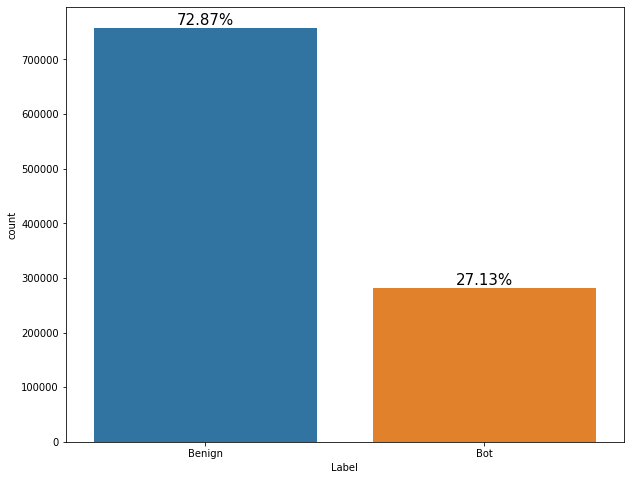

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,8))
plot = sns.countplot(df["Label"], order = df["Label"].value_counts().index);
for label, bar in zip(df["Label"].value_counts().index, plot.patches):
  percentage = bar.get_height() / len(df)
  plot.text(bar.get_x() + bar.get_width()/2, bar.get_height() +5000, s = f"{round(percentage * 100, 2)}%", ha = "center", size = 15)

##PCA (Principal Component Analysis):

In [20]:
#Applying PCA on numerical features only:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
num_cols = [col for col in df.columns if (is_numeric_dtype(df[col]) & (col != "Timestamp") & (col != "Dst Port"))]
len(num_cols)

58

In [21]:
from sklearn.preprocessing import StandardScaler
x = df.loc[:, num_cols].values #Just numerical columns
x = StandardScaler().fit_transform(x)

In [22]:
x.shape

(1040558, 58)

In [23]:
np.mean(x),np.std(x)

(1.1756696443843645e-17, 0.999999999999999)

In [24]:
feat_cols = ['feature'+str(i) for i in range(x.shape[1])]

In [25]:
normalised_df = pd.DataFrame(x,columns=feat_cols)

In [26]:
normalised_df.tail()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57
1040553,-0.252176,0.090436,0.004505,0.482930,-0.011549,1.91875,-0.395422,0.831997,1.159702,1.642838,-0.429003,0.6778,1.427471,-0.047919,-0.117296,-0.243710,-0.152834,-0.284870,-0.235726,-0.244036,-0.249915,-0.127791,-0.263402,-0.238061,-0.101820,0.008521,-0.106055,-0.115617,0.001359,0.042789,0.006189,-0.107132,-0.063202,-0.423005,1.602649,0.586065,1.079602,0.552480,-0.581032,0.533687,0.831997,0.6778,0.090436,0.482930,0.004505,-0.011552,0.095966,2.158300,0.353439,0.493822,-0.059254,-0.04878,-0.06926,-0.047376,-0.275711,-0.073044,-0.278,-0.270946
1040554,-0.258128,0.090436,0.004505,0.482007,-0.011549,1.91875,-0.395422,0.829519,1.160190,1.642838,-0.429003,0.6778,1.427471,-0.047917,-0.117294,-0.244219,-0.158964,-0.285680,-0.235725,-0.250011,-0.250733,-0.127848,-0.260413,-0.236464,-0.110179,-0.002251,-0.120285,-0.117498,0.013147,0.042789,0.006189,-0.107131,-0.063200,-0.423005,1.602649,0.585259,1.079805,0.552707,-0.581032,0.532875,0.829519,0.6778,0.090436,0.482007,0.004505,-0.011552,0.095966,2.158384,0.353439,0.493822,-0.059254,-0.04878,-0.06926,-0.047376,-0.275711,-0.073044,-0.278,-0.270946
1040555,-0.251446,0.090436,0.004505,0.490772,-0.011549,1.97860,-0.395422,0.853060,1.200788,1.642838,-0.429003,0.6778,1.427471,-0.047919,-0.117296,-0.243648,-0.144803,-0.283912,-0.235725,-0.243303,-0.249814,-0.118783,-0.263373,-0.238354,-0.102805,0.007252,-0.085522,-0.083474,-0.001306,0.042789,0.006189,-0.107132,-0.063202,-0.423005,1.602649,0.592911,1.089749,0.563869,-0.581032,0.540584,0.853060,0.6778,0.090436,0.490772,0.004505,-0.011552,0.095966,2.161164,0.353439,0.493822,-0.059254,-0.04878,-0.06926,-0.047376,-0.275711,-0.073044,-0.278,-0.270946
1040556,-0.251638,0.090436,0.004505,0.490772,-0.011549,1.97860,-0.395422,0.853060,1.200788,1.642838,-0.429003,0.6778,1.427471,-0.047919,-0.117296,-0.243664,-0.149648,-0.284872,-0.235726,-0.243496,-0.249841,-0.127886,-0.265964,-0.238794,-0.100932,0.009666,-0.104935,-0.105103,0.013578,0.042789,0.006189,-0.107132,-0.063202,-0.423005,1.602649,0.592911,1.089749,0.563869,-0.581032,0.540584,0.853060,0.6778,0.090436,0.490772,0.004505,-0.011552,0.095966,2.157584,0.353439,0.493822,-0.059254,-0.04878,-0.06926,-0.047376,-0.275711,-0.073044,-0.278,-0.270946
1040557,-0.252491,0.090436,0.004505,0.481546,-0.011549,1.91875,-0.395422,0.828280,1.160440,1.642838,-0.429003,0.6778,1.427471,-0.047919,-0.117296,-0.243737,-0.149195,-0.284870,-0.235725,-0.244353,-0.249958,-0.123448,-0.263301,-0.238270,-0.101627,0.008770,-0.093808,-0.111588,0.017934,0.042789,0.006189,-0.107132,-0.063202,-0.423005,1.602649,0.584857,1.079908,0.552823,-0.581032,0.532470,0.828280,0.6778,0.090436,0.481546,0.004505,-0.011552,0.095966,2.162007,0.353439,0.493822,-0.059254,-0.04878,-0.06926,-0.047376,-0.275711,-0.073044,-0.278,-0.270946


In [27]:
from sklearn.decomposition import PCA
pca_df = PCA(n_components=0.95) #in order to visualize properly we will use 2 components
principalComponents_df = pca_df.fit_transform(x)

In [28]:
principal_df = pd.DataFrame(data = principalComponents_df
             , columns = ["p" + str(i + 1) for i in range(principalComponents_df.shape[1])])

In [29]:
principal_df.tail()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19
1040553,3.346181,2.328627,-0.696987,1.973842,-0.096084,0.296744,0.325336,0.110222,-0.459297,0.385781,0.288259,-1.066996,0.089101,0.201628,-0.146652,-0.415254,0.043663,-0.018547,-0.408241
1040554,3.337722,2.332439,-0.696032,1.983180,-0.091255,0.299679,0.322254,0.108217,-0.460530,0.386308,0.297285,-1.063642,0.094641,0.200433,-0.150117,-0.417370,0.044180,-0.012500,-0.406715
1040555,3.395438,2.344177,-0.707698,1.981656,-0.098170,0.298131,0.346897,0.125089,-0.479927,0.380852,0.257869,-1.060034,0.086620,0.198756,-0.148937,-0.409729,0.040058,-0.015259,-0.403995
1040556,3.386432,2.348417,-0.706377,1.991782,-0.093273,0.302059,0.348194,0.125877,-0.485137,0.382022,0.278274,-1.056407,0.089244,0.199861,-0.144975,-0.407462,0.042411,-0.021530,-0.396900
1040557,3.349164,2.325481,-0.697592,1.965816,-0.102083,0.292372,0.328198,0.109586,-0.465453,0.386783,0.294154,-1.067552,0.090290,0.201223,-0.149135,-0.417275,0.043136,-0.013980,-0.412234


In [30]:
print('Explained variation per principal component: {}'.format(pca_df.explained_variance_ratio_), 
      f"\ncomulates to: {round(sum(pca_df.explained_variance_ratio_)*100, 2)}% of the variation of the data.")

Explained variation per principal component: [0.20552295 0.17982199 0.11152592 0.07596417 0.05981415 0.05294312
 0.03770605 0.03604977 0.03024926 0.02555291 0.02311041 0.01822857
 0.01682948 0.01621289 0.01594292 0.01524001 0.01392134 0.0119535
 0.01045122] 
comulates to: 95.7% of the variation of the data.


Now the data is reduced from 80 features into: 19 Numerical features, 10 Categorical, 1 Timestamp, and the Outcome label.

##Splitting Timestamp into date and time

In [31]:
df[['Date','Time']] = df['Timestamp'].str.split(expand=True)

In [32]:
df = df.drop('Timestamp', 1)

In [33]:
df.sample(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Date,Time
257689,3389,6,119677999,106,104,51,5304.0,51,0,0.481132,4.953558,51,51,51.000000,0.000000,44.745066,1.754708,572622.0048,546415.106800,1931571.0,82568.0,120000000.0,1.139790e+06,355853.208300,2017585.0,86244.0,119000000.0,1.151209e+06,343613.125600,2015626.0,1015503.0,1,2120,2080,0.885710,0.868998,0,51,25.620853,25.560355,653.331754,0,1,0,0,1,0,0,0,25.742857,0.481132,51.000000,106,51,104,5304,62773,62773,0,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,02/03/2018,01:26:51
1013706,3389,6,3997093,13,8,1438,1731.0,725,0,110.615385,196.450392,1179,0,216.375000,405.464791,792.826186,5.253818,199854.6500,318151.369000,991977.0,3.0,3997093.0,3.330911e+05,415049.630300,1204046.0,3.0,3935776.0,5.622537e+05,482037.971400,1202183.0,107549.0,0,272,172,3.252364,2.001455,0,1179,144.045455,283.771786,80526.426410,0,0,1,1,0,0,1,0,150.904762,110.615385,216.375000,13,1438,8,1731,8192,62647,7,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,02/03/2018,04:05:53
358176,3389,6,1903048,8,7,1144,1581.0,677,0,143.000000,227.969923,1173,0,225.857143,430.098604,1431.913436,7.882092,135932.0000,245654.148600,953105.0,68.0,1903048.0,2.718640e+05,394336.107400,1157204.0,68.0,1754522.0,2.924203e+05,324523.138700,953105.0,146332.0,0,172,152,4.203783,3.678310,0,1173,170.312500,319.402717,102018.095800,0,0,1,1,0,0,1,0,181.666667,143.000000,225.857143,8,1144,7,1581,8192,62856,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,02/03/2018,08:47:39
411339,53,17,85917,1,1,58,144.0,58,58,58.000000,0.000000,144,144,144.000000,0.000000,2351.106300,23.278280,85917.0000,0.000000,85917.0,85917.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,8,8,11.639140,11.639140,58,144,86.666667,49.652123,2465.333333,0,0,0,0,0,0,0,1,130.000000,58.000000,144.000000,1,58,1,144,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,02/03/2018,08:47:05
671600,53,17,987,1,1,35,51.0,35,35,35.000000,0.000000,51,51,51.000000,0.000000,87132.725430,2026.342452,987.0000,0.000000,987.0,987.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,8,8,1013.171226,1013.171226,35,51,40.333333,9.237604,85.333333,0,0,0,0,0,0,0,1,60.500000,35.000000,51.000000,1,35,1,51,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,02/03/2018,11:02:02
916262,53,17,42926,1,1,32,140.0,32,32,32.000000,0.000000,140,140,140.000000,0.000000,4006.895588,46.591809,42926.0000,0.000000,42926.0,42926.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0,8,8,23.295905,23.295905,32,140,68.000000,62.353829,3888.000000,0,0,0,0,0,0,0,1,102.000000,32.000000,140.000000,1,32,1,140,-1,-1,0,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,02/03/2018,05:18:41
1016055,3389,6,1697291,9,7,1128,1581.0,661,0,125.333333,213.483020,1173,0,225.857143,430.098604,1596.072801,9.426787,113152.7333,241162.466600,969032.0,129.0,1697291.0,2.121614e+05,359841.351800,1098728.0,7037.0,1613543.0,2.689238e+05,346592.228700,969032.0,91755.0,0,192,152,5.302567,4.124219,0,1173,159.352941,310.370533,96329.867650,0,0,1,1,0,0,1,0,169.312500,125.333333,225.857143,9,1128,7,1581,8192,62872,5,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B

In [34]:
df['Time'] = df['Time'].str.replace(':','')
df['Date'] = df['Date'].str.replace('/','')

In [35]:
#Notice that the date is the same in all rows ----> redundunt column:
df.drop("Date",axis=1,inplace=True)

In [36]:
df.sample(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Time
872544,3389,6,3500217,9,7,1144,1581.0,677,0,127.111111,218.508835,1173,0,225.857143,430.098604,778.523160,4.571145,233347.800000,3.336160e+05,1032806.0,4.0,3500217.0,437527.1250,4.254060e+05,1164049.0,4.0,3347534.0,557922.333300,5.170156e+05,1429938.0,137906.0,0,192,152,2.571269,1.999876,0,1173,160.294118,312.006764,97348.220590,0,0,0,1,0,0,0,0,170.312500,127.111111,225.857143,9,1144,7,1581,8192,62856,5,20,0.0000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,Benign,012129
336581,8080,6,11283,3,4,326,129.0,326,0,108.666667,188.216188,112,0,32.250000,53.767245,40326.154390,620.402375,1880.500000,4.126131e+03,10293.0,17.0,631.0,315.5000,3.740595e+02,580.0,51.0,10720.0,3573.333333,5.820489e+03,10293.0,101.0,0,72,92,265.886732,354.515643,0,326,56.875000,115.406657,13318.696430,0,0,1,1,0,0,1,1,65.000000,108.666667,32.250000,3,326,4,129,8192,219,1,20,0.0000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,Bot,014321
390817,53,17,1068,1,1,35,249.0,35,35,35.000000,0.000000,249,249,249.000000,0.000000,265917.603000,1872.659176,1068.000000,0.000000e+00,1068.0,1068.0,0.0,0.0000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0,8,8,936.329588,936.329588,35,249,106.333333,123.552958,15265.333330,0,0,0,0,0,0,0,1,159.500000,35.000000,249.000000,1,35,1,249,-1,-1,0,8,0.0000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,Benign,102816
324859,8080,6,9382,3,4,326,129.0,326,0,108.666667,188.216188,112,0,32.250000,53.767245,48497.122150,746.109572,1563.666667,3.393683e+03,8482.0,1.0,572.0,286.0000,2.644579e+02,473.0,99.0,8942.0,2980.666667,4.769795e+03,8482.0,1.0,0,72,92,319.761245,426.348327,0,326,56.875000,115.406657,13318.696430,0,0,1,1,0,0,1,1,65.000000,108.666667,32.250000,3,326,4,129,8192,219,1,20,0.0000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,Bot,111850
167614,8080,6,492,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,4065.040650,492.000000,0.000000e+00,492.0,492.0,492.0,492.0000,0.000000e+00,492.0,492.0,0.0,0.000000,0.000000e+00,0.0,0.0,0,40,0,4065.040650,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,2052,-1,0,20,0.0000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,Bot,104831
311373,53,17,208,1,1,51,67.0,51,51,51.000000,0.000000,67,67,67.000000,0.000000,567307.692300,9615.384615,208.000000,0.000000e+00,208.0,208.0,0.0,0.0000,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0,8,8,4807.692308,4807.692308,51,67,56.333333,9.237604,85.333333,0,0,0,0,0,0,0,1,84.500000,51.000000,67.000000,1,51,1,67,-1,-1,0,8,0.0000,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,Benign,090048
927481,443,6,67290768,153,251,5320,340784.0,517,0,34.771242,118.799560,1460,0,1357.705179,346.104309,5143.409866,6.003795,166974.610400,1.229616e+06,10000000.0,1.0,62700000.0,412573.4211,1.959894e+06,10100000.0,25.0,67200000.0,268787.112000,1.568225e+06,10100000.0,1.0,0,3608,5104,2.273715,3.730081,0,1460,854.577778,702.168975,493041.269300,0,0,0,1,0,0,0,1,856.693069,34.771242,1357.705179,153,5320,251,340784,8192,329,19,20,464945.3333,963576.8229,2431823.0,68221.0,9986914.667,54983.02633,10000000.0,9874888.0,Benign,020253
61113,8080,6,486,2,0,0,0

##Converting labels to numbers

In [37]:
df.Label.replace("Benign", 0, inplace = True)
df.Label.replace("Bot", 1, inplace = True)

In [38]:
df.sample(10)

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Time
627699,3389,6,1307579,8,7,1148,1581.0,677,0,143.500000,228.129662,1173,0,225.857143,430.098604,2087.063191,11.471582,9.339850e+04,2.530624e+05,968753.0,3.0,1307579.0,1.867970e+05,3.806467e+05,1048899.0,3.0,1260273.0,2.100455e+05,3.719054e+05,968753.0,49124.0,0,172,152,6.118177,5.353405,0,1173,170.562500,319.433242,102037.595800,0,0,0,1,0,0,0,0,181.933333,143.500000,225.857143,8,1148,7,1581,8192,62852,5,20,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,0,022344
652197,9135,6,86168916,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.023210,8.620000e+07,0.000000e+00,86200000.0,86200000.0,86200000.0,8.620000e+07,0.000000e+00,86200000.0,86200000.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40,0,0.023210,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,62558,-1,0,20,0.0,0.00000,0.0,0.0,86200000.0,0.0000,86200000.0,86200000.0,0,011206
774295,53,17,369,1,1,35,67.0,35,35,35.000000,0.000000,67,67,67.000000,0.000000,276422.764200,5420.054201,3.690000e+02,0.000000e+00,369.0,369.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,8,8,2710.027100,2710.027100,35,67,45.666667,18.475209,341.333333,0,0,0,0,0,0,0,1,68.500000,35.000000,67.000000,1,35,1,67,-1,-1,0,8,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,0,112921
903045,443,6,116914581,15,13,852,7915.0,254,0,56.800000,84.928710,1460,0,608.846154,699.280326,74.986370,0.239491,4.330170e+06,1.560000e+07,58500000.0,1.0,117000000.0,8.351042e+06,2.120000e+07,58500000.0,33.0,117000000.0,9.736217e+06,2.270000e+07,58600000.0,1.0,0,312,272,0.128299,0.111192,0,1460,302.310345,540.699025,292355.436000,0,0,0,1,0,0,0,0,313.107143,56.800000,608.846154,15,852,13,7915,8192,64,7,20,138650.0,85994.08409,199457.0,77843.0,58300000.0,331460.5463,58500000.0,58000000.0,0,114237
259379,8080,6,10814,3,4,326,129.0,326,0,108.666667,188.216188,112,0,32.250000,53.767245,42075.087850,647.309044,1.802333e+03,3.957292e+03,9869.0,22.0,621.0,3.105000e+02,3.655742e+02,569.0,52.0,10267.0,3.422333e+03,5.585782e+03,9869.0,22.0,0,72,92,277.418162,369.890882,0,326,56.875000,115.406657,13318.696430,0,0,1,1,0,0,1,1,65.000000,108.666667,32.250000,3,326,4,129,8192,219,1,20,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,1,015621
131914,8080,6,10115,3,4,326,129.0,326,0,108.666667,188.216188,112,0,32.250000,53.767245,44982.698960,692.041522,1.685833e+03,3.687983e+03,9205.0,2.0,587.0,2.935000e+02,2.821356e+02,493.0,94.0,9653.0,3.217667e+03,5.189933e+03,9205.0,2.0,0,72,92,296.589224,395.452299,0,326,56.875000,115.406657,13318.696430,0,0,1,1,0,0,1,1,65.000000,108.666667,32.250000,3,326,4,129,8192,219,1,20,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,1,111731
764414,80,6,82,2,0,0,0.0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,24390.243900,8.200000e+01,0.000000e+00,82.0,82.0,82.0,8.200000e+01,0.000000e+00,82.0,82.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,40,0,24390.243900,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.000000,0.000000,0.000000,2,0,0,0,278,-1,0,20,0.0,0.00000,0.0,0.0,0.0,0.0000,0.0,0.0,0,112042
133064,8080,6,10331,3,4,326,129.0,326,0,108.666

In [39]:
df.shape

(1040558, 70)

##Adding the rest of the columns into the principal dataframe

In [40]:
rest_cols = [col for col in df.columns if col not in num_cols]
df_cleaned = principal_df.copy()
for col in rest_cols:
  df_cleaned[col] = df[col]
df_cleaned.sample(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,Dst Port,Protocol,Fwd PSH Flags,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Label,Time
290472,-0.414562,1.151412,-0.165181,1.045436,-0.536190,0.068868,0.718543,0.108034,-0.578960,-0.437419,-0.766881,1.185992,-0.091821,-0.177261,0.268035,0.527140,0.140332,0.051856,0.342604,8080,6,0,0,0,1,1,0,0,1,1,115154
642635,-2.645391,0.004409,0.262425,-0.097646,-1.412664,-0.374778,-0.214836,-0.364617,0.770772,0.008794,0.250714,-0.207063,0.079788,-0.064843,-0.192875,-0.132094,-0.159551,0.070551,0.059491,53358,6,0,0,0,0,0,1,0,0,0,042320
824448,-2.182607,0.253718,0.189099,0.089524,-1.179710,-0.275107,0.016736,-0.314666,0.600736,-0.038433,0.101358,-0.011554,0.089800,-0.131264,-0.117555,-0.101129,-0.137764,0.111935,0.271491,443,6,1,0,1,0,0,1,0,0,0,114846
11617,-2.206022,0.299387,0.633330,-0.753311,-0.156557,-0.361094,-0.158395,-0.490949,0.280088,-1.575577,-0.318866,4.254448,-0.726235,-0.043781,1.404266,1.495375,1.291694,-0.099354,-1.823459,8080,6,0,0,0,1,1,0,0,1,1,113232
133233,-2.628121,-0.022692,0.257636,-0.063535,-1.382689,-0.360894,-0.111100,-0.472794,0.799162,0.003287,0.249250,-0.180058,0.072377,-0.094530,-0.134804,-0.204719,-0.159987,0.085288,-0.011794,8080,6,0,0,0,0,0,1,0,0,1,112253
752582,-2.659944,0.056195,0.327694,-0.250324,-1.291848,-0.414754,-0.618423,0.083190,0.522771,-0.284158,0.101902,0.844075,-0.209179,0.736319,0.177273,-0.532011,-0.031378,0.036161,-0.150915,50313,6,0,0,0,0,0,1,1,0,0,105051
349004,-2.627946,-0.022712,0.257597,-0.063505,-1.382122,-0.360665,-0.108636,-0.475361,0.799998,0.003188,0.249261,-0.179690,0.072293,-0.095268,-0.133498,-0.206559,-0.160249,0.085354,-0.011768,8080,6,0,0,0,0,0,1,0,0,1,035128
609825,-2.451691,0.539989,0.488281,-1.733843,1.977176,0.087760,0.252904,0.203620,-0.227923,0.073449,-0.191720,-0.137306,-0.060114,0.057688,0.041910,-0.026311,0.020885,-0.041446,-0.043012,53,17,0,0,0,0,0,0,0,0,0,013506
843418,2.110347,-6.185043,-0.318972,-3.747213,-1.907130,-1.432462,0.800905,0.078554,-0.199110,-0.201352,-2.985622,0.032257,0.764280,-1.027816,-2.494587,-1.175001,-1.566660,5.035219,3.969206,443,6,1,0,1,0,0,1,0,0,0,092052
591424,3.813853,2.684411,-0.867996,2.213831,0.236682,0.398065,0.240415,0.030514,-0.790897,0.270488,0.028739,-0.765836,0.166733,0.108390,-0.221232,-0.314415,-0.053406,0.104230,-0.126229,3389,6,0,0,0,0,1,0,0,0,0,035650


In [41]:
df_cleaned["Label"] = df_cleaned["Label"].astype("category")
df_cleaned["Time"] = df_cleaned["Time"].astype("int64")

##Last step: converting port number into 3 dummy variables (0, 6, 17)

In [42]:
df.Protocol.unique()

array([6, 0, 17], dtype=object)

In [43]:
dummy = pd.get_dummies(df.Protocol)
df_cleaned["protocol_0"] = dummy[0]
df_cleaned["protocol_6"] = dummy[6]
df_cleaned["protocol_17"] = dummy[17]
df_cleaned.drop("Protocol",axis=1,inplace=True)
df_cleaned.sample(10)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,Dst Port,Fwd PSH Flags,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,ECE Flag Cnt,Label,Time,protocol_0,protocol_6,protocol_17
612327,-1.906255,0.303434,0.071855,0.695697,-1.282971,-0.177095,0.161844,-0.387528,0.168101,0.234537,0.321929,-0.958139,0.159979,0.105027,-0.265114,-0.577042,-0.036382,0.189521,-0.843350,3389,0,0,0,1,1,0,0,1,0,90502,0,1,0
37007,3.829127,2.653582,-0.868349,2.183317,0.215861,0.385051,0.265783,0.038492,-0.827550,0.276638,0.100055,-0.765346,0.164387,0.115265,-0.203761,-0.306531,-0.047909,0.073118,-0.113092,3389,0,0,0,1,1,0,0,1,0,104922,0,1,0
992022,-2.649865,0.056665,0.325146,-0.248443,-1.265050,-0.401964,-0.473523,-0.072644,0.580247,-0.281129,0.114837,0.764400,-0.166485,0.506140,0.162786,-0.365872,-0.005217,0.036446,-0.159459,51232,0,0,0,0,0,1,1,0,0,124729,0,1,0
126644,-0.414443,1.151346,-0.165201,1.045313,-0.536192,0.068845,0.718986,0.107611,-0.578822,-0.437416,-0.766902,1.185774,-0.091739,-0.177728,0.267873,0.527664,0.140396,0.051877,0.342530,8080,0,0,0,1,1,0,0,1,1,103628,0,1,0
482557,-2.363780,0.563870,0.492077,-1.785998,2.057313,0.083895,0.190739,0.108475,-0.145522,0.088026,-0.099343,-0.163281,-0.049569,0.011208,0.031765,0.012118,0.033310,-0.032525,-0.108531,53,0,0,0,0,0,0,0,0,0,122749,0,0,1
941741,-2.641067,0.055502,0.322883,-0.244952,-1.242903,-0.391309,-0.355749,-0.199300,0.626531,-0.278732,0.125241,0.700290,-0.132019,0.319203,0.151205,-0.230653,0.016658,0.037376,-0.170667,51704,0,0,0,0,0,1,1,0,0,13944,0,1,0
509581,-2.250903,0.717681,0.516727,-2.078325,2.801146,0.159612,0.274913,0.269709,-0.368528,0.153023,-0.218914,-0.275258,-0.050798,0.019993,-0.020911,-0.004243,0.023487,-0.026566,-0.077777,53,0,0,0,0,0,0,0,0,0,84950,0,0,1
61584,-0.414531,1.151396,-0.165186,1.045403,-0.536192,0.068861,0.718646,0.107932,-0.578921,-0.437419,-0.766901,1.185937,-0.091805,-0.177371,0.267997,0.527264,0.140347,0.051860,0.342579,8080,0,0,0,1,1,0,0,1,1,111455,0,1,0
322981,-2.637596,0.002164,0.260598,-0.094260,-1.389107,-0.365133,-0.113764,-0.469880,0.804585,0.004613,0.251029,-0.191161,0.076086,-0.095029,-0.139111,-0.207201,-0.169583,0.074151,0.055398,8080,0,0,0,0,0,1,0,0,1,111059,0,1,0
10131,-2.627928,-0.022714,0.257593,-0.063502,-1.382063,-0.360641,-0.108382,-0.475625,0.800084,0.003177,0.249263,-0.179652,0.072284,-0.095344,-0.133363,-0.206748,-0.160276,0.085361,-0.011765,8080,0,0,0,0,0,1,0,0,1,112638,0,1,0


#Splitting Data

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop("Label", axis=1), df_cleaned["Label"], test_size=0.3) 

#Training

##Decision Tree

In [45]:
from sklearn import tree
DT = tree.DecisionTreeClassifier(criterion='gini')
DT = DT.fit(X_train, y_train)

###Evaluation

In [46]:
from sklearn import metrics
def eval(model):
  y_pred = model.predict(X_test)

  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test, y_pred))
  print("==========================================================")

  cm = metrics.confusion_matrix(y_test, y_pred)
  print(metrics.classification_report(y_test, y_pred))

  print("==========================================================")
  print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred))

In [47]:
eval(DT)

Accuracy: 0.9999743727736347
Precision: 0.9999173641525694
Recall: 0.999988194042714
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227465
           1       1.00      1.00      1.00     84703

    accuracy                           1.00    312168
   macro avg       1.00      1.00      1.00    312168
weighted avg       1.00      1.00      1.00    312168

Confusion Matrix:
 [[227458      7]
 [     1  84702]]


##The Decision Tree model could deal with the massive size of the dataset (one million record) and the results were amazing, however for other models to deal with this size and for the resources limitations we should sample the data:

In [48]:
sample_df = df_cleaned.sample(int(len(df_cleaned) * 0.2))
sample_df.shape

(208111, 33)

In [49]:
#splitting the data again:
X_train, X_test, y_train, y_test = train_test_split(sample_df.drop("Label", axis=1), sample_df["Label"], test_size=0.3) 

##K-Nearest Neighbours

In [50]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

Evaluation was not applicable due to resources limitations.
so we pick a sample of the test set

In [51]:
eval(KNN)

Accuracy: 0.9992792388762534
Precision: 0.9983136593591906
Recall: 0.9990689013035382
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45250
           1       1.00      1.00      1.00     17184

    accuracy                           1.00     62434
   macro avg       1.00      1.00      1.00     62434
weighted avg       1.00      1.00      1.00     62434

Confusion Matrix:
 [[45221    29]
 [   16 17168]]


**Support Vector Machine**

For the support vector machine we should split even into smaller sample, let's say (20000) record.

In [52]:
sample_df = df_cleaned.sample(int(len(df_cleaned) * 0.002))
sample_df.shape

(2081, 33)

In [53]:
#splitting the data again:
X_train, X_test, y_train, y_test = train_test_split(sample_df.drop("Label", axis=1), sample_df["Label"], test_size=0.3) 

In [54]:
from sklearn import svm

SVM = svm.SVC(kernel='linear') # Linear Kernel

SVM.fit(X_train, y_train)

SVC(kernel='linear')

In [55]:
eval(SVM)

Accuracy: 0.7856
Precision: 0.675
Recall: 0.18243243243243243
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       477
           1       0.68      0.18      0.29       148

    accuracy                           0.79       625
   macro avg       0.73      0.58      0.58       625
weighted avg       0.77      0.79      0.73       625

Confusion Matrix:
 [[464  13]
 [121  27]]


**Naive Bayesian**

In [56]:
sample_df = df_cleaned.sample(int(len(df_cleaned) * 0.2))
sample_df.shape

(208111, 33)

In [57]:
#splitting the data again:
X_train, X_test, y_train, y_test = train_test_split(sample_df.drop("Label", axis=1), sample_df["Label"], test_size=0.3) 

In [58]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train,y_train)

GaussianNB()

In [59]:
eval(NB)

Accuracy: 0.5302399333696384
Precision: 0.3660622722611333
Recall: 0.983872859488623
              precision    recall  f1-score   support

           0       0.98      0.36      0.53     45382
           1       0.37      0.98      0.53     17052

    accuracy                           0.53     62434
   macro avg       0.67      0.67      0.53     62434
weighted avg       0.81      0.53      0.53     62434

Confusion Matrix:
 [[16328 29054]
 [  275 16777]]


**Neural Network**

In [60]:
sample_df = df_cleaned.sample(int(len(df_cleaned) * 0.2))
sample_df.shape

(208111, 33)

In [61]:
#splitting the data again:
X_train, X_test, y_train, y_test = train_test_split(sample_df.drop("Label", axis=1), sample_df["Label"], test_size=0.3) 
#providing the validation set:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5) 

In [62]:
X_train.shape

(145677, 32)

In [63]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, input_dim=32, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',])
# fit the keras model on the dataset
history = model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs=5, batch_size=64,
                    validation_data=(np.asarray(X_val).astype('float32'), np.asarray(y_val).astype('float32')))

Epoch 1/5
2277/2277 [==============================] - 10s 3ms/step - loss: 39.9792 - accuracy: 0.8315 - val_loss: 41.6986 - val_accuracy: 0.7280
Epoch 2/5
2277/2277 [==============================] - 7s 3ms/step - loss: 9.6687 - accuracy: 0.9133 - val_loss: 12.0151 - val_accuracy: 0.9173
Epoch 3/5
2277/2277 [==============================] - 7s 3ms/step - loss: 2.9377 - accuracy: 0.9502 - val_loss: 1.3764 - val_accuracy: 0.9672
Epoch 4/5
2277/2277 [==============================] - 7s 3ms/step - loss: 1.2697 - accuracy: 0.9649 - val_loss: 0.6112 - val_accuracy: 0.9765
Epoch 5/5
2277/2277 [==============================] - 7s 3ms/step - loss: 0.5434 - accuracy: 0.9704 - val_loss: 0.1017 - val_accuracy: 0.9926


(0.0, 1.0)

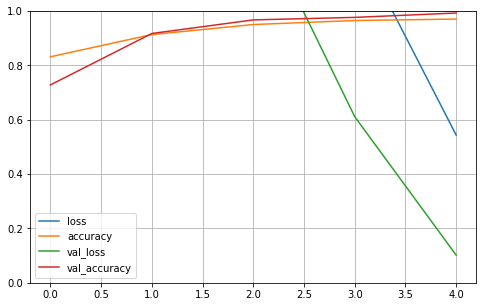

In [64]:
plt=pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.set_ylim(0, 1)

In [65]:
def eval_neural(model, X_test, y_test):

  y_pred = model.predict(X_test)

  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Precision:",metrics.precision_score(y_test, y_pred))
  print("Recall:",metrics.recall_score(y_test, y_pred))
  print("==========================================================")

  #cm = metrics.confusion_matrix(y_test, y_pred)
  #print(metrics.classification_report(y_test, y_pred))

  #print("==========================================================")
  #print("Confusion Matrix:\n",metrics.confusion_matrix(y_test, y_pred))

In [66]:
loss, accuracy = model.evaluate(np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32'))
print(f"The accuracy of the model is: {round(accuracy*100,2)}%")

976/976 [==============================] - 2s 2ms/step - loss: 0.0813 - accuracy: 0.9922
The accuracy of the model is: 99.22%


In [74]:
y_pred = model.predict(np.asarray(X_test).astype('float32'))
y_pred = [np.round(i) for i in y_pred]
print("Accuracy:",metrics.accuracy_score(np.asarray(y_test).astype('float32'), y_pred))
print("Precision:",metrics.precision_score(np.asarray(y_test).astype('float32'), y_pred))
print("Recall:",metrics.recall_score(np.asarray(y_test).astype('float32'), y_pred))
print("==========================================================")

cm = metrics.confusion_matrix(np.asarray(y_test).astype('float32'), y_pred)
print(metrics.classification_report(np.asarray(y_test).astype('float32'), y_pred))

print("==========================================================")
print("Confusion Matrix:\n",metrics.confusion_matrix(np.asarray(y_test).astype('float32'), y_pred))

Accuracy: 0.9922157798635359
Precision: 0.9879733269826149
Recall: 0.9831733617727219
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     22778
         1.0       0.99      0.98      0.99      8439

    accuracy                           0.99     31217
   macro avg       0.99      0.99      0.99     31217
weighted avg       0.99      0.99      0.99     31217

Confusion Matrix:
 [[22677   101]
 [  142  8297]]
